# Sequence Learning - Phone Training - English
Version 2:  This version has a core structure using HM-RNN. Unlike traditional approaches, our model can automatically detect boundaries. It is trainable and updates the upper layer only upon detecting boundaries. This makes our model suitable for detecting boundaries and capturing the representations of sub-segments based on these detected boundaries. In essence, our model performs boundary detection and representation learning simultaneously.

Version 3: this version completed the coding of the core model structure as well as the dataloading, preprocessing, padding and loss calculation processes. At present we only try mel->model -> mel structure, since wav <> wav would introduce extra complexion. In addition, our model will process padded multi-batch tensors as normal but count for the paddings (ignore paddings) during calculation. 

Version 4: this version is testing whether our hmrnn is not working. It imports a modified version of model: model_test

Version 5: this version is testing phase two, mainly working on preprocessing modifications. 

Version 6: this version deletes lin2, as this will destroy the predicted segmental boundaries. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pack_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle
from paths import *
from my_utils import *
from recorder import *
from padding import generate_mask_from_lengths_mat, mask_it, masked_loss
from datetime import datetime

In [2]:
# from model import PhonLearn_Net
from model import PhonLearn_Net

### Dirs

In [3]:
model_save_dir = model_eng_save_dir
# random_data:phone_seg_random_path
# anno_data: phone_seg_anno_path

# random_log_path = phone_seg_random_log_path + "log.csv"
random_log_path = word_seg_anno_log_path
random_path = word_seg_anno_path
anno_log_path = phone_seg_anno_path

### Constants

In [4]:
# 规范用语；规定两种方式：全加载；按rec加载（舍弃了按chunk加载，处理起来更简单）
# RandomPhoneDataset; AnnoPhoneDataset; AnnoSeqDataset

In [5]:
class PhoneDataset(Dataset):
    """
    A PyTorch dataset that loads cutted wave files from disk and returns input-output pairs for
    training autoencoder. 
    
    Version 3: wav -> mel
    """
    
    def __init__(self, load_dir, load_control_path, transform=None):
        """
        Initializes the class by reading a CSV file and merging the "rec" and "idx" columns.

        The function reads the CSV file from the provided control path, extracts the "rec" and "idx" columns,
        and concatenates the values from these columns using an underscore. It then appends the ".wav" extension
        to each of the merged strings and converts the merged pandas Series to a list, which is assigned to
        the 'dataset' attribute of the class.

        Args:
        load_dir (str): The directory containing the files to load.
        load_control_path (str): The path to the CSV file containing the "rec" and "idx" columns.

        Attributes:
        dataset (list): A list of merged strings from the "rec" and "idx" columns, with the ".wav" extension.
        """
        control_file = pd.read_csv(load_control_path)
        control_file = control_file[control_file['n_frames'] > 400]
        control_file = control_file[control_file['duration'] <= 2.0]
        
        # Extract the "rec" and "idx" columns
        rec_col = control_file['rec'].astype(str)
        idx_col = control_file['idx'].astype(str).str.zfill(8)
        
        # Merge the two columns by concatenating the strings with '_' and append extension name
        merged_col = rec_col + '_' + idx_col + ".wav"
        
        self.dataset = merged_col.tolist()
        self.load_dir = load_dir
        self.transform = transform
        
    
    def __len__(self):
        """
        Returns the length of the dataset.
        
        Returns:
            int: The number of input-output pairs in the dataset.
        """
        return len(self.dataset)
    
    def __getitem__(self, idx):
        """
        Returns a tuple (input_data, output_data) for the given index.

        The function first checks if the provided index is a tensor, and if so, converts it to a list.
        It then constructs the file path for the .wav file using the dataset attribute and the provided index.
        The .wav file is loaded using torchaudio, and its data is normalized. If a transform is provided,
        the data is transformed using the specified transform. Finally, the input_data and output_data are
        set to the same data (creating a tuple), and the tuple is returned.

        Args:
        idx (int or torch.Tensor): The index of the desired data.

        Returns:
        tuple: A tuple containing input_data and output_data, both of which are the audio data
               from the .wav file at the specified index.

        Note: 
        This function assumes that the class has the following attributes:
        - self.load_dir (str): The directory containing the .wav files.
        - self.dataset (list): A list of .wav file names.
        - self.transform (callable, optional): An optional transform to apply to the audio data.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        wav_name = os.path.join(self.load_dir,
                                self.dataset[idx])
        
        data, sample_rate = torchaudio.load(wav_name, normalize=True)
        if self.transform:
            data = self.transform(data, sr=sample_rate)
        
        # # Prepare for possible in-out discrepencies in the future
        # input_data = data
        # output_data = data
        
        return data

def collate_fn(xx):
    # only working for one data at the moment
    batch_first = True
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=batch_first, padding_value=0)
    return xx_pad, x_lens


class MyTransform(nn.Module): 
    def __init__(self, sample_rate, n_fft): 
        super().__init__()
        # self.transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, n_mels=64)
        # self.to_db = torchaudio.transforms.AmplitudeToDB()
        # self.transform = torchaudio.transforms.MFCC(n_mfcc=13)
    
    def forward(self, waveform, sr=16000): 
        # extract mfcc
        feature = torchaudio.compliance.kaldi.mfcc(waveform, sample_frequency=sr)

        # add deltas
        d1 = torchaudio.functional.compute_deltas(feature)
        d2 = torchaudio.functional.compute_deltas(d1)
        feature = torch.cat([feature, d1, d2], dim=-1)

        # Apply normalization (CMVN)
        eps = 1e-9
        mean = feature.mean(0, keepdim=True)
        std = feature.std(0, keepdim=True, unbiased=False)
        # print(feature.shape)
        # print(mean, std)
        feature = (feature - mean) / (std + eps)

        # mel_spec = self.transform(waveform)
        # # mel_spec = self.to_db(mel_spec)
        # mel_spec = mel_spec.squeeze()
        # mel_spec = mel_spec.permute(1, 0) # (F, L) -> (L, F)
        return feature

In [6]:
BATCH_SIZE = 128

# INPUT_DIM = 128
# OUTPUT_DIM = 128

INPUT_DIM = 39
OUTPUT_DIM = 13

INTER_DIM_0 = 16
INTER_DIM_1 = 8
INTER_DIM_2 = 3
INTER_DIM_3 = 3

SIZE_LIST = [INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400

LOADER_WORKER = 16

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
recon_loss = nn.MSELoss(reduction='none')
# model = TwoRNNAttn(1.0, SIZE_LIST, in_size=INPUT_DIM, 
#                       in2_size=INTER_DIM_0, hid_size=INTER_DIM_3, out_size=OUTPUT_DIM)
model = PhonLearn_Net(1.0, SIZE_LIST, in_size=INPUT_DIM, 
                      in2_size=INTER_DIM_0, hid_size=SIZE_LIST[1], out_size=OUTPUT_DIM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [8]:
model

PhonLearn_Net(
  (encoder): Encoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=39, out_features=16, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): HM_LSTM(
      (cell_1): HM_LSTMCell()
      (cell_2): HM_LSTMCell()
    )
  )
  (decoder): Decoder(
    (lin_1): LinearPack(
      (linear): Linear(in_features=13, out_features=3, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (rnn): LSTM(3, 16, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=16, out_features=16, bias=True)
      (w_k): Linear(in_features=3, out_features=16, bias=True)
      (w_v): Linear(in_features=3, out_features=16, bias=True)
    )
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=13, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [10]:
params

3727

In [11]:
# Just for keeping records of training hists. 
ts = str(get_timestamp())
# ts = "0130021416"
save_txt_name = "train_txt_{}.hst".format(ts)
save_trainhist_name = "train_hist_{}.hst".format(ts)
save_valhist_name = "val_hist_{}.hst".format(ts)

In [12]:
valid_losses = LossRecorder(model_save_dir + save_valhist_name)
train_losses = LossRecorder(model_save_dir + save_trainhist_name)
text_hist = HistRecorder(model_save_dir + save_txt_name)

In [13]:
READ = False
# READ = True

In [14]:
if READ: 
    valid_losses.read()
    train_losses.read()

    # model_name = last_model_namec
    model_name = "PT_0130021416_9.pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)
    model = PhonLearn_Net()
    model.load_state_dict(state)
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

In [15]:
mytrans = MyTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT)
ds = PhoneDataset(random_path, os.path.join(random_log_path, "log.csv"), transform=mytrans)
# small_len = int(0.1 * len(ds))
# other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
# ds, other_ds = random_split(ds, [small_len, other_len])

train_len = int(0.8 * len(ds))
valid_len = len(ds) - train_len

# Randomly split the dataset into train and validation sets
train_ds, valid_ds = random_split(ds, [train_len, valid_len])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=LOADER_WORKER, collate_fn=collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=collate_fn)
valid_num = len(valid_loader.dataset)

In [16]:
len(train_loader)

1776

In [17]:
EPOCHS = 30
BASE = 0

In [18]:
def train(): 
    for epoch in range(BASE, BASE + EPOCHS):
        text_hist.print("Epoch {}".format(epoch))

        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        for idx, (x, x_lens) in enumerate(train_loader):
            optimizer.zero_grad()
            batch = x.size(0)
            batch, length, dim = x.shape
            y = x[:, :, :13]    # extract MFCC-only data
            
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, _ = model(x, x_mask) # _ = hidden, z_1, z_2

            # print(y)
            # print(recon_x)
            # raise Exception

            
            loss = masked_loss(recon_loss, recon_x, y, x_mask)
            # loss = recon_loss(recon_x, x)

            train_loss += loss.item()
            # loss = loss / batch

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            if idx % 100 == 0:
                text_hist.print(f"Training loss {loss: .3f} in Step {idx}")

        train_losses.append(train_loss / train_num)
        text_hist.print(f"※※※Training loss {train_loss / train_num: .3f}※※※")

        last_model_name = "PT_{}_{}_full.pt".format(ts, epoch)
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))
        text_hist.print("Training timepoint saved")

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        for idx, (x, x_lens) in enumerate(valid_loader):
            # batch = x.size(0)
            y = x[:, :, :13]    # extract MFCC-only data
            x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
            
            x = x.to(device)
            y = y.to(device)

            recon_x, _ = model(x, x_mask) # _ = hidden, z_1, z_2

            loss = masked_loss(recon_loss, recon_x, y, x_mask)
            # loss = recon_loss(recon_x, x)
            valid_loss += loss.item()

            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()

            if idx % 100 == 0:
                # \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f}
                text_hist.print(f"Valid loss {loss: .3f} in Step {idx}")

        valid_losses.append(valid_loss / valid_num)
        text_hist.print(f"※※※Valid loss {valid_loss / valid_num: .3f}※※※")

In [19]:
if __name__ == "__main__": 
    train()

Epoch 0
Training loss  1.136 in Step 0
Training loss  1.000 in Step 100
Training loss  0.999 in Step 200
Training loss  1.000 in Step 300
Training loss  1.000 in Step 400
Training loss  0.999 in Step 500
Training loss  0.998 in Step 600
Training loss  0.996 in Step 700
Training loss  0.989 in Step 800
Training loss  0.989 in Step 900
Training loss  0.987 in Step 1000
Training loss  0.990 in Step 1100
Training loss  0.982 in Step 1200
Training loss  0.983 in Step 1300
Training loss  0.987 in Step 1400
Training loss  0.980 in Step 1500
Training loss  0.977 in Step 1600
Training loss  0.982 in Step 1700
※※※Training loss  0.993※※※
Training timepoint saved
Valid loss  0.974 in Step 0
Valid loss  0.970 in Step 100
Valid loss  0.968 in Step 200
Valid loss  0.969 in Step 300
Valid loss  0.973 in Step 400
※※※Valid loss  0.971※※※
Epoch 1
Training loss  0.980 in Step 0
Training loss  0.981 in Step 100
Training loss  0.974 in Step 200
Training loss  0.981 in Step 300
Training loss  0.982 in Step 4

In [20]:
### Save
valid_losses.save()
train_losses.save()
text_hist.save()

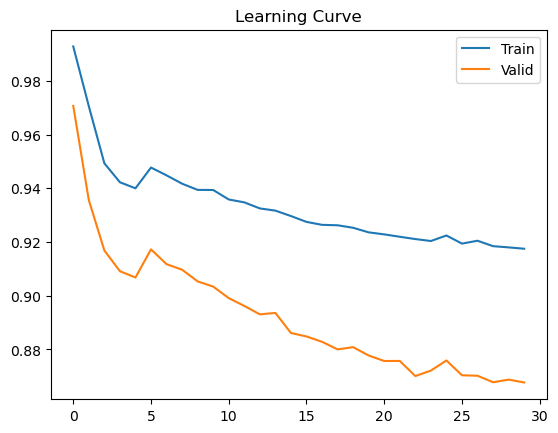

In [21]:
plt.plot(train_losses.get(), label='Train')
plt.plot(valid_losses.get(), label='Valid')
plt.title("Learning Curve")
plt.legend()

In [25]:
ts

'0613160106'

We can see that with Sigmoid the model seems to perform slightly worse, but this should not be a big problem. Then the decision might depend more on whether the use of it is common and justifiable. I don't think it's common, and the use of it does not seem to be analytically necessary. 

In [ ]:
class ResAECluster(ResAE): 
    def __init__(self, input_dim=INPUT_DIM, inter_dim1=INTER_DIM_1, inter_dim2=INTER_DIM_2, inter_dim3=INTER_DIM_3, latent_dim=LATENT_DIM, output_dim=OUTPUT_DIM): 
        super().__init__(input_dim, inter_dim1, inter_dim2, inter_dim3, latent_dim, output_dim)

    def forward(self, x):
        org_size = x.size()
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        # mu, logvar = h.chunk(2, dim=1)
        # z = self.reparameterise(mu, logvar)

        return h

In [ ]:
seq = "_01_05"
tags = pd.read_csv(tags_name + seq + ".csv")
gsds = GroundedSoundDataset(tags, test_name + seq + ".npy")
eval_loader = DataLoader(gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
last_model_name

'model_english_0130021416_29_full'

In [ ]:
# model_name = last_model_name
model_name = "model_english_0130021416_13_full"
model_path = save_dir + model_name + ".pt"
state = torch.load(model_path)
model = ResAECluster()
model.load_state_dict(state)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
hiddens = None
tags = None
model.eval()
with torch.no_grad():
    for idx, (s, e, t) in enumerate(eval_loader):
        s = s.to(device)
        hidden = model(s)
        hidden = hidden.cpu().data.numpy()

        if hiddens is not None: 
            hiddens = np.concatenate((hiddens, hidden), axis=0)
            tags = np.concatenate((tags, t), axis=0)
        else: 
            hiddens = hidden
            tags = t
num_phones = np.unique(tags).shape[0]
kmeansmodel = KMeans(n_clusters=num_phones) # , random_state=0
clusters = kmeansmodel.fit_predict(hiddens)
np.save(save_dir + model_name + seq + "_hiddenclusters.npy", clusters)
np.save(save_dir + model_name + seq + "_hiddenrepresentation.npy", hiddens)


In [ ]:
h, c, v = homogeneity_completeness_v_measure(tags, clusters)

In [ ]:
print(seq, h, c, v) # trained on sampled data

_01_05 0.30813685860010276 0.2726217590636009 0.2892933823757265


In [ ]:
# _17_24 0.3429902101084872 0.329164358854651 0.33593508938856537   # 256+8
# _17_24 0.3071758873778334 0.2958512436337788 0.3014072290332542   # 128+4
# _17_24 0.3048181747064378 0.303971996633573 0.3043944976042278    # 128+2
# _17_24 0.3109960687106377 0.3020004935745723 0.3064322772063619   # 256+2, 2res
# _17_24 0.27632046463064963 0.29796767719078493 0.28673608598337974    # 256+64+2, 2res, new model
# _17_24 0.29619001674434664 0.30940705212658304 0.30265430485339223    # 256+64+4, 0res
# _17_24 0.3394207670351701 0.3356821861468344 0.33754112484613674      # 256+64+4, 2res
# _17_24 0.3246121630042821 0.3173438869288583 0.32093687897447765  # 256+3, 2res, not very bad. So we may try this. This is error, decoder only having 1 res
# _17_24 0.3227539602867097 0.32256957773330264 0.3226617426690128  # 256+3, 2res
# _17_24 0.3403517130774138 0.33762198107176034 0.33898135170147237 # 256+3, 1res
# _17_24 0.3202704367215642 0.31097127191607643 0.3155523587925454  # 256+3, 0res


# _01_05 0.30784101366300043 0.2717512535534188 0.28867252408265254

总的来说分成四个，神经网层来进行降维处理，得到的损失比较大，但是 hcv值倒是接近不过，如果能尽量的接近原作的模型结构，我们就不去动它了，所以可能目前来看最好的是保留两个降为层加上两个残差层，最后从256降到2，也许是最好的结果当然降到4也是可以的，都是比较低的维度，不过如果我们想要直接能够，在，可视的空间中画出这些点来，2或者3可能会比四更好一些。 

从使用不同数量残插块儿的实验结果来看，是由一个残渣块，应该是最好的解决方式，使用零个或两个第三个都可能是都会使hcv值相对降低。由此来看在选择，隐性层纬度为三的情况下，我们应该选择适用一个参差款。

### Conclusion
Adding new data slightly improves the performance of the model in HCV score, in addition, shuffling the training data largely lowers the HGV score perhaps we should discuss this phenomenon and justify use no shuffling during training. Perhaps this is because of some sort of phonotactics or naturalness of sound streams. 

Good news is that for the English model it performs similar well. 